In [103]:
%cd /root/share/Real/KAIST/Production_management

%load_ext autoreload
%autoreload 2

/root/share/Real/KAIST/Production_management
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import numpy as np
import pandas as pd
import datetime
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

In [105]:
def evaluation(y_true, y_pred):
    test_data['Sales']
    print("MAD: {}, MAPD: {}".format(mean_absolute_error(y_true, y_pred), mean_absolute_percentage_error(y_true, y_pred)))

In [106]:
data = pd.read_csv("Data/processed_data.csv", index_col=0).reset_index()

In [107]:
data.head(30)

,index,Date,Sales,Weekday
0,1,2023-01-02,712500,0
1,2,2023-01-03,817500,1
2,3,2023-01-04,734000,2
3,4,2023-01-05,473500,3
4,5,2023-01-06,757000,4
5,7,2023-01-08,551500,6
6,8,2023-01-09,404000,0
7,9,2023-01-10,346000,1
8,10,2023-01-11,617500,2
9,11,2023-01-12,645500,3


In [108]:
train_data_pre = data.loc[1:259]
test_data = data.loc[260:] #11월

In [109]:
train_data = train_data_pre.copy()
train_data.loc[train_data["Sales"]==0, 'Sales'] = np.nan

non_missing_data = train_data.dropna()
x = non_missing_data.index.values
y = non_missing_data['Sales']
spline = interp1d(x, y, kind='cubic', bounds_error=False, fill_value="extrapolate")

x_missing = train_data.index[train_data['Sales'].isna()]
train_data.loc[train_data['Sales'].isna(), 'Sales'] = spline(x_missing)

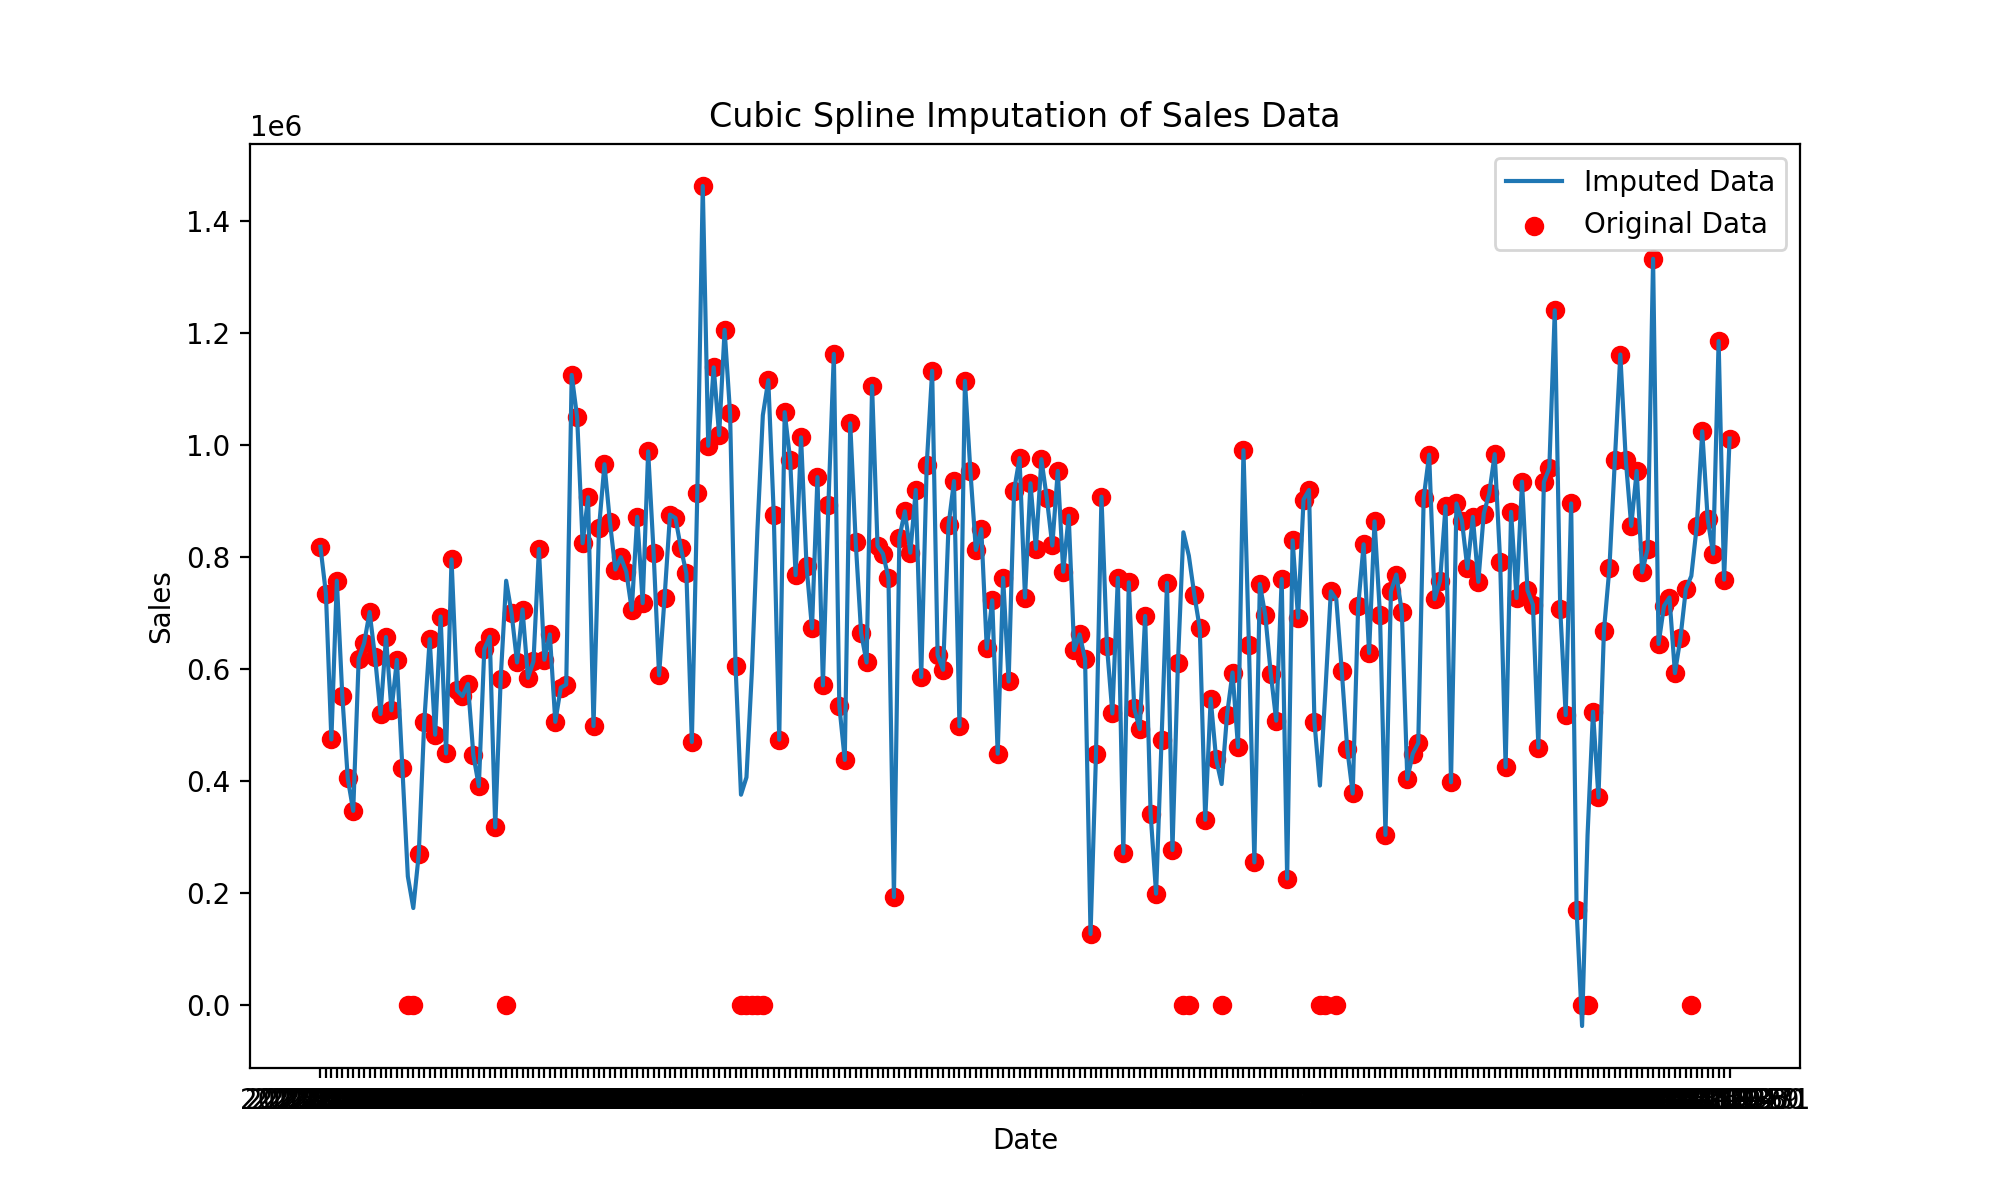

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], train_data['Sales'], label='Imputed Data')
plt.scatter(train_data_pre['Date'], train_data_pre['Sales'], color='red', label='Original Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Cubic Spline Imputation of Sales Data')
plt.show()

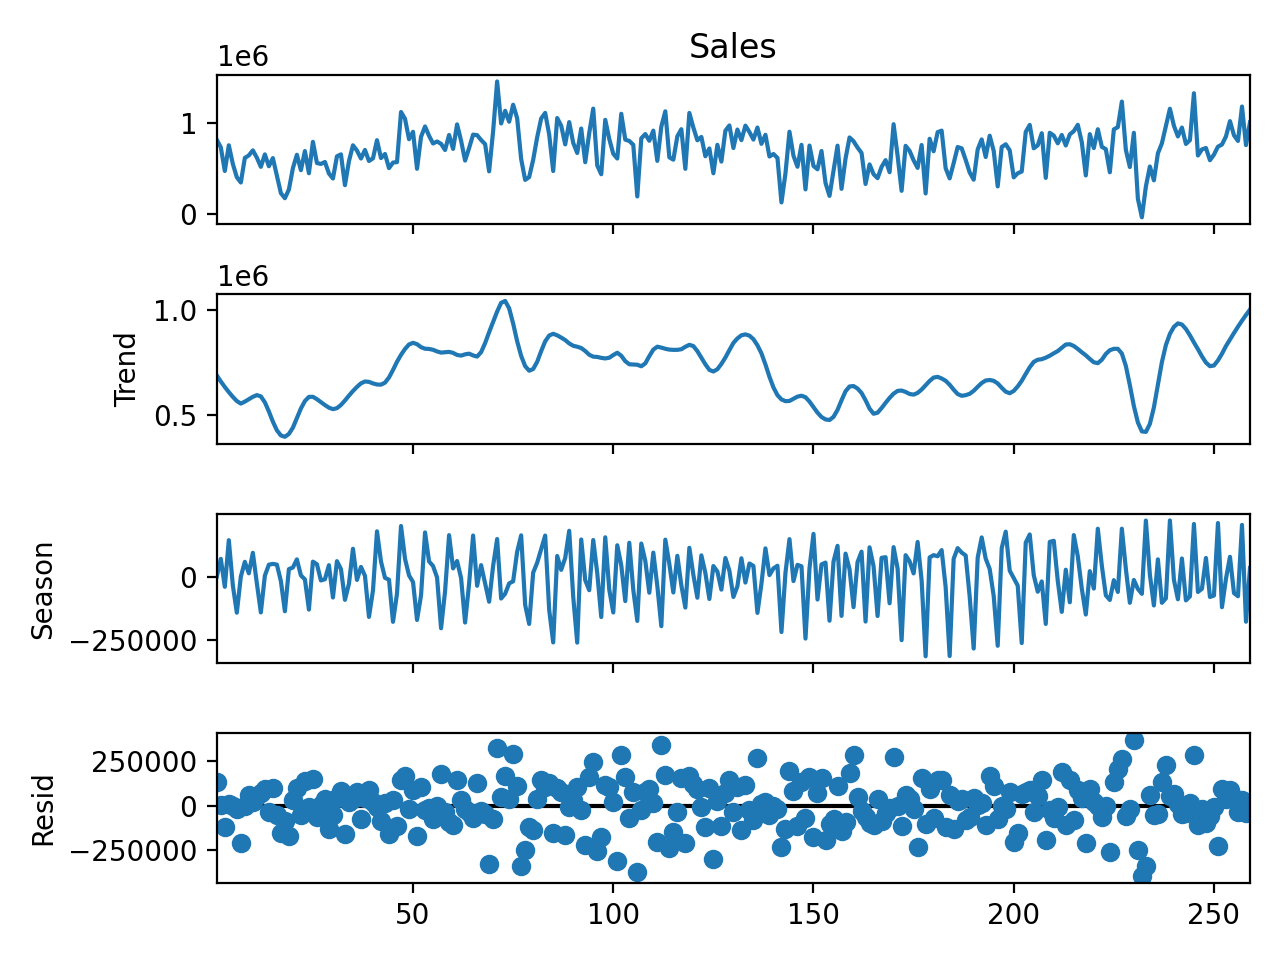

In [111]:
stl = STL(train_data['Sales'], period=6)
res = stl.fit()
fig = res.plot()

In [112]:
stlf = STLForecast(train_data['Sales'], ARIMA, period=30, model_kwargs=(dict(order=(2, 1, 5))))
res = stlf.fit()
y_pred = res.forecast(len(test_data))
y_true = test_data['Sales']
evaluation(y_true=y_true, y_pred=y_pred)

MAD: 242280.6874243822, MAPD: 0.3024403110917921


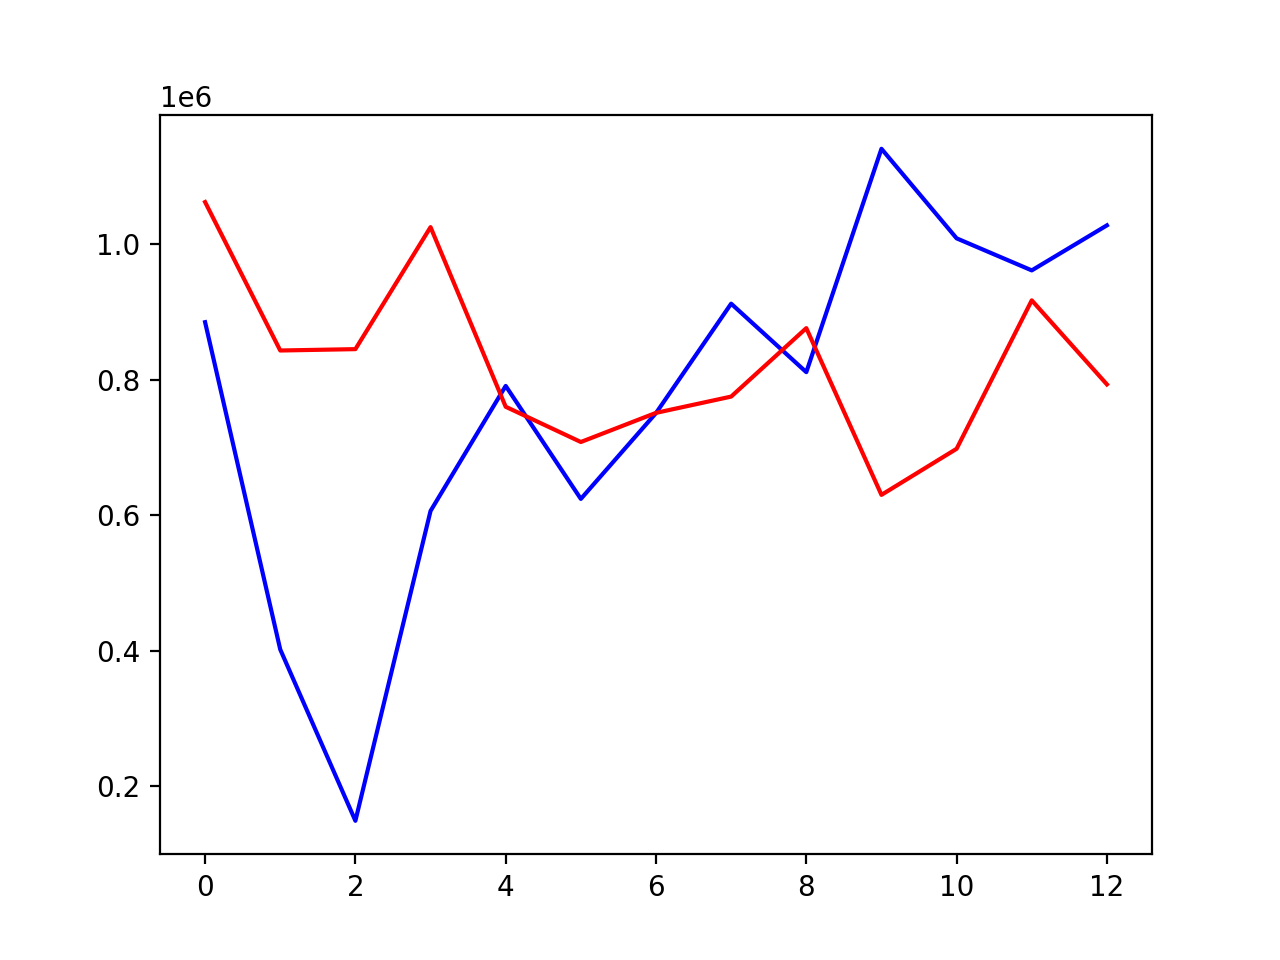

In [113]:
plt.plot(np.array(y_pred), color="blue")
plt.plot(np.array(y_true), color="red")

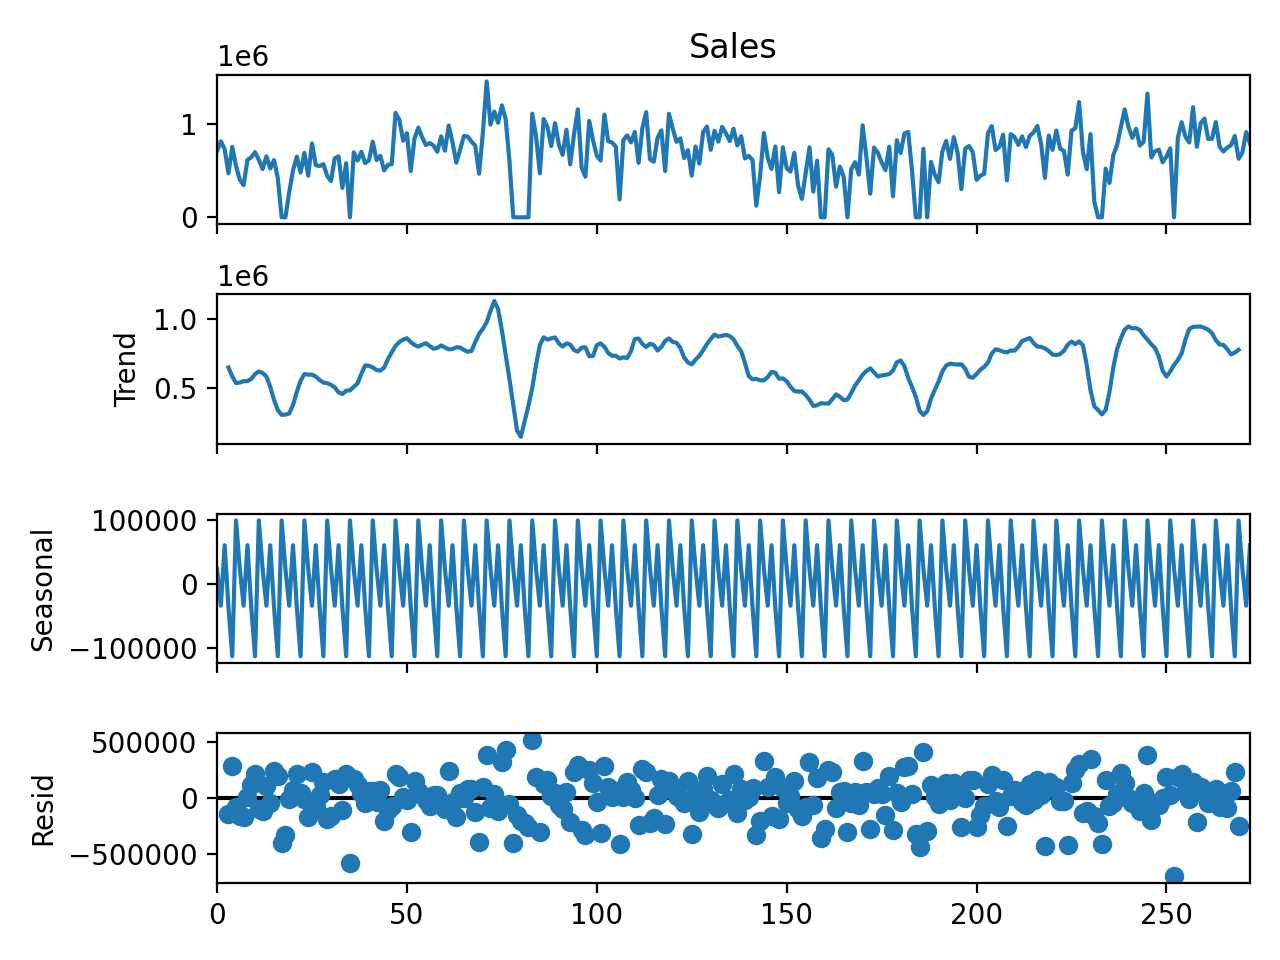

In [114]:
decomposed = seasonal_decompose(data['Sales'], model='additive', period=6)
#plt.rcParams['figure.figsize'] = [12, 8]
decomposed.plot()
plt.show()

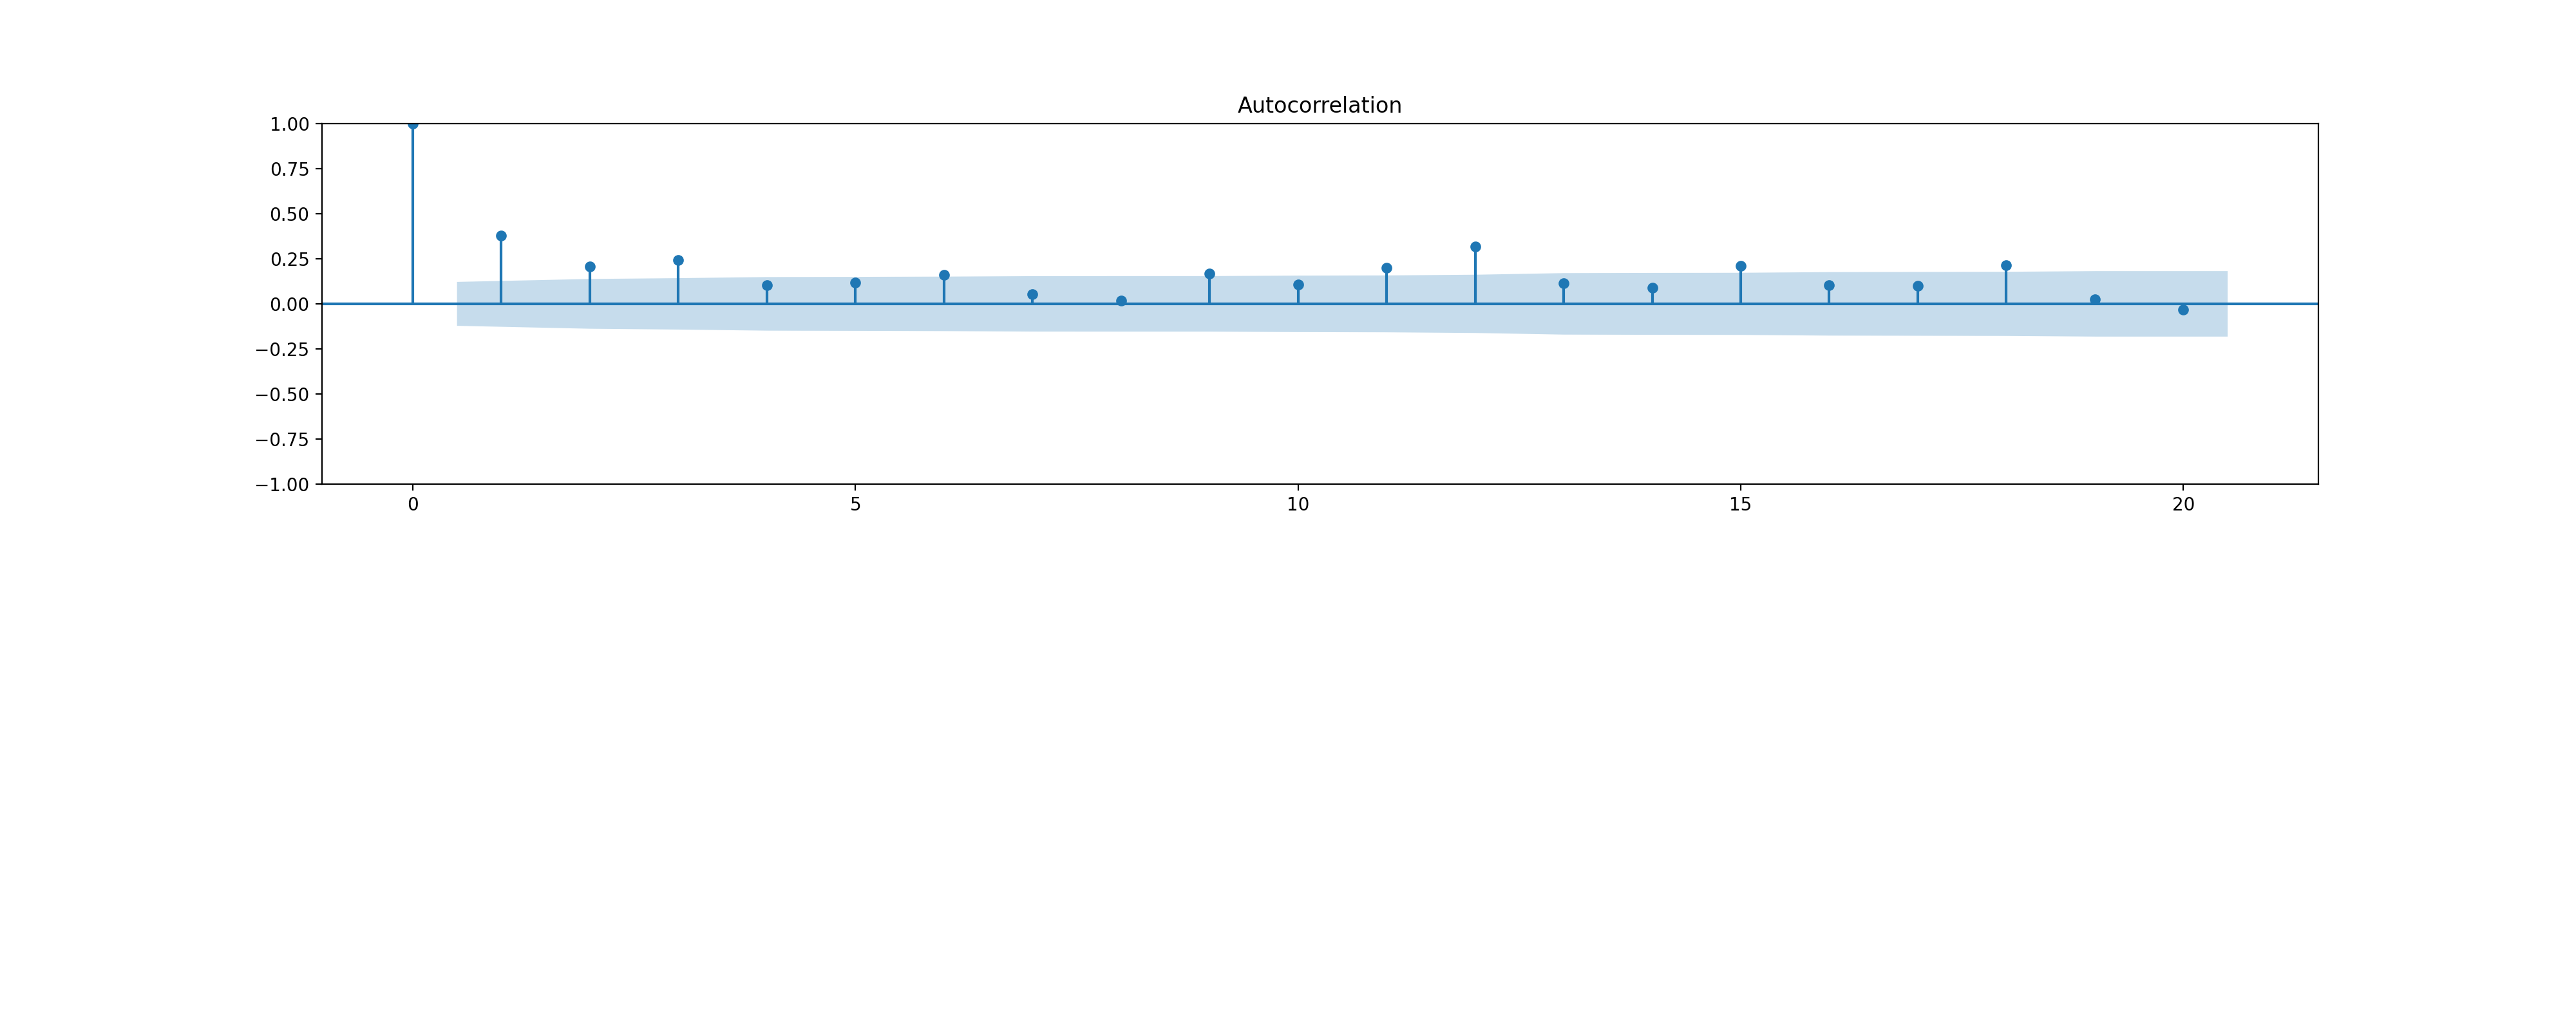

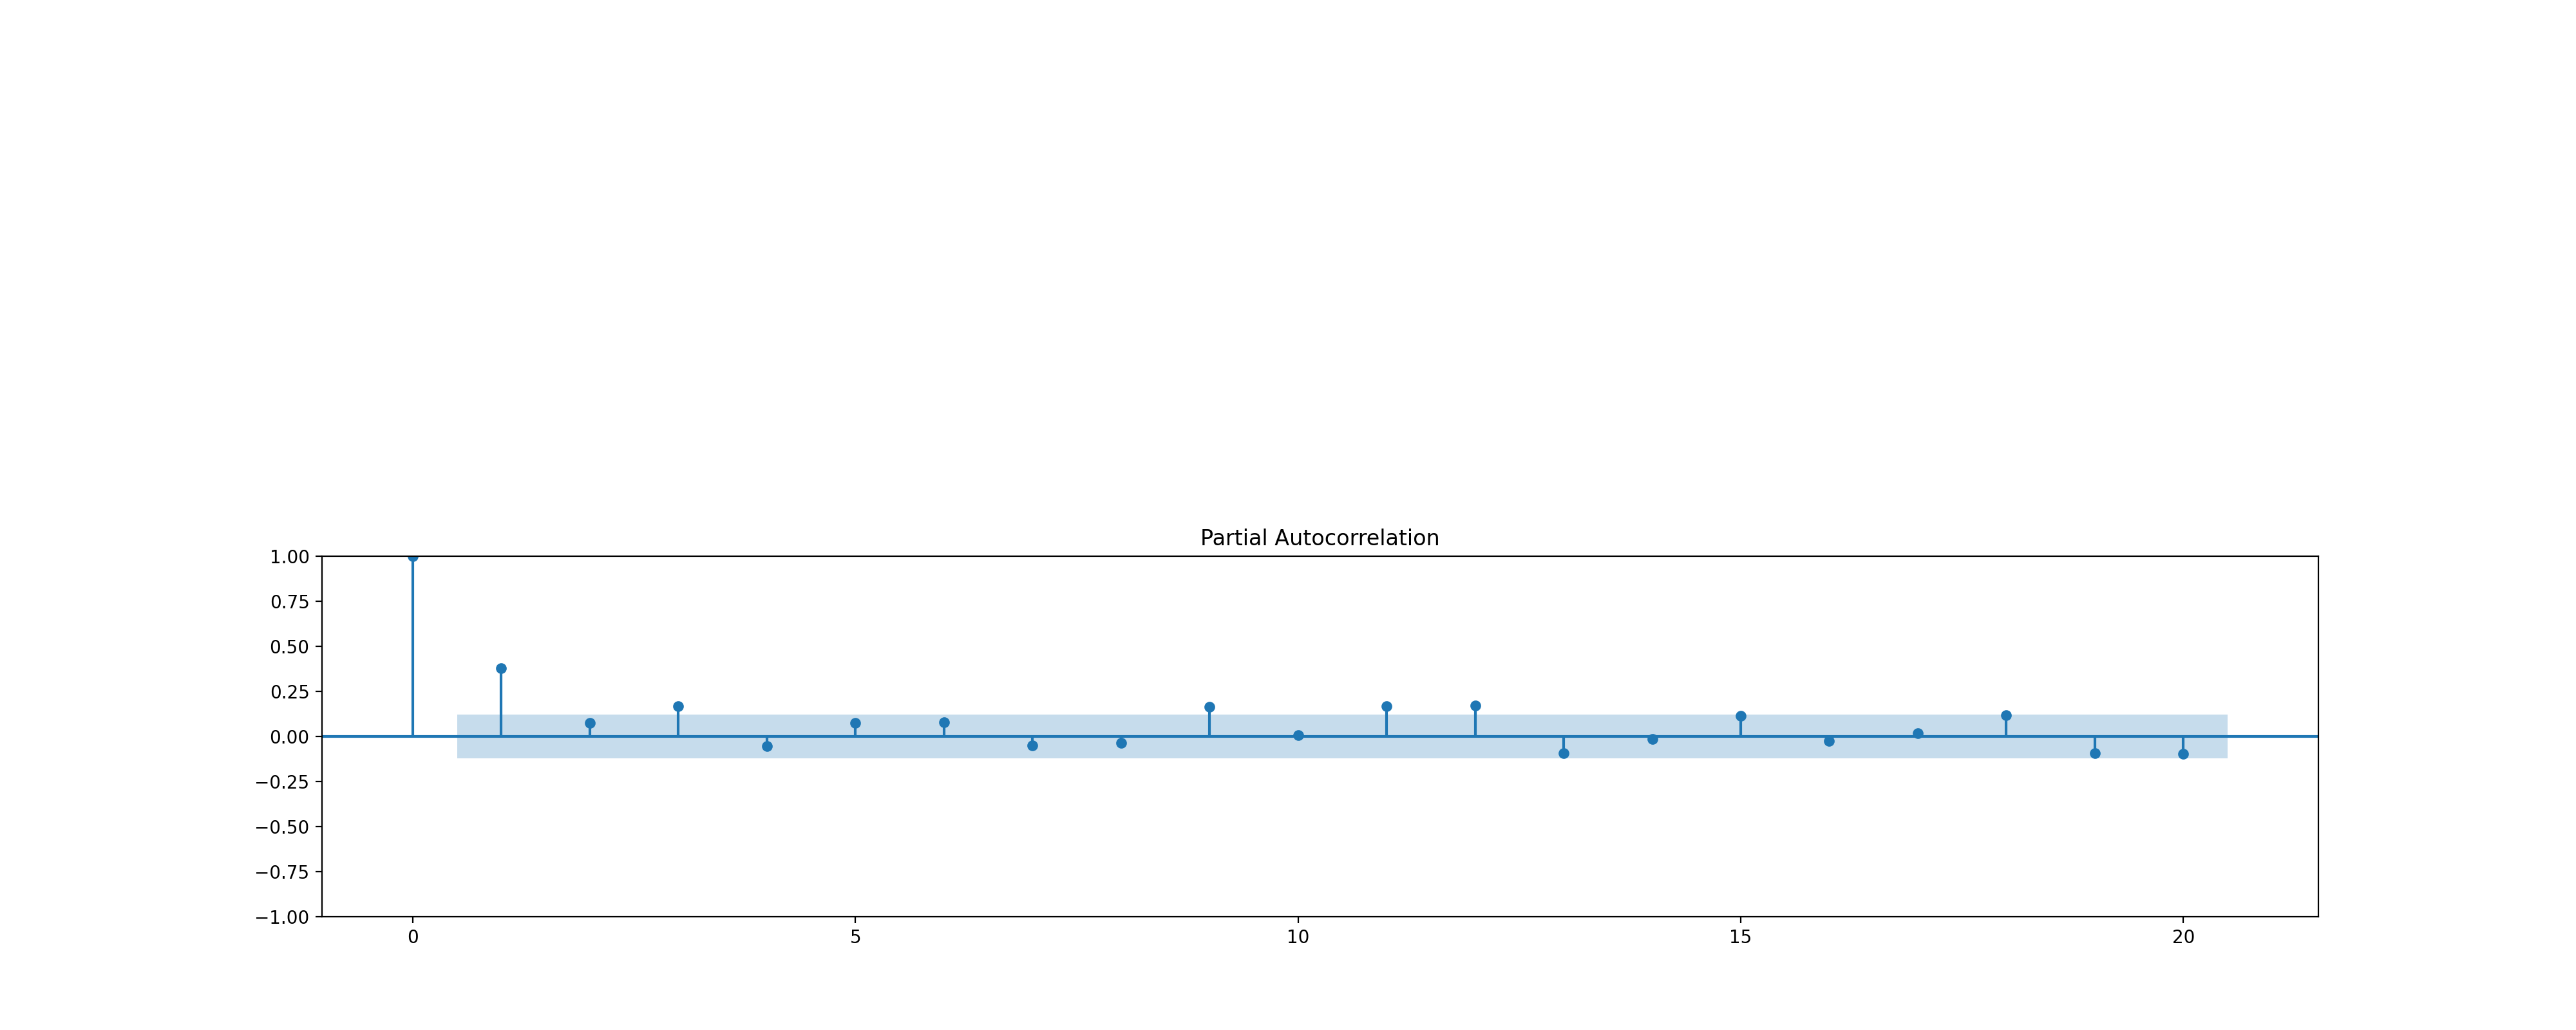

In [115]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data["Sales"], lags=20, ax=ax1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data["Sales"], lags=20, ax=ax1)

In [116]:
import itertools
from tqdm import tqdm 

p = range(0,3)
d = range(0,3)
q = range(0,6)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = ARIMA(train_data["Sales"], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

  0%|          | 0/54 [00:00<?, ?it/s]

 26%|██▌       | 14/54 [00:00<00:00, 40.47it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 61%|██████    | 33/54 [00:01<00:00, 24.12it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
/opt/conda/lib/python

In [117]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
print(optimal)
model_opt = ARIMA(train_data["Sales"], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


[((2, 1, 4), 7053.12)]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  259
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -3519.561
Date:                Sun, 19 Nov 2023   AIC                           7053.123
Time:                        08:08:23   BIC                           7077.993
Sample:                             0   HQIC                          7063.123
                                - 259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9642      0.016    -58.549      0.000      -0.996      -0.932
ar.L2         -0.9816      0.016    -61.528      0.000      -1.013      -0.950
ma.L1          0.3397      0.064      5.337      0.000       0.215       0.464
ma.L2          0.1364      0.048      2.850      0.004       0.043       0.230
ma.L3         -0.8322      0.047    -17.674      0.000      -0.924      -0.740
ma.L4         -0.3000      0.061     -4.933      0.000      -0.419      -0.181
sigma2      4.629e+10   1.45e-13   3.19e+23      0.000    4.63e+10    4.63e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.87
Prob(Q):                              0.88   Prob(JB):                         0.05
Heteroskedasticity (H):               1.39   Skew:                            -0.27
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+40. Standard errors may be unstable.
"""

In [118]:
model = ARIMA(train_data["Sales"], order=optimal[0][0])
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data))

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


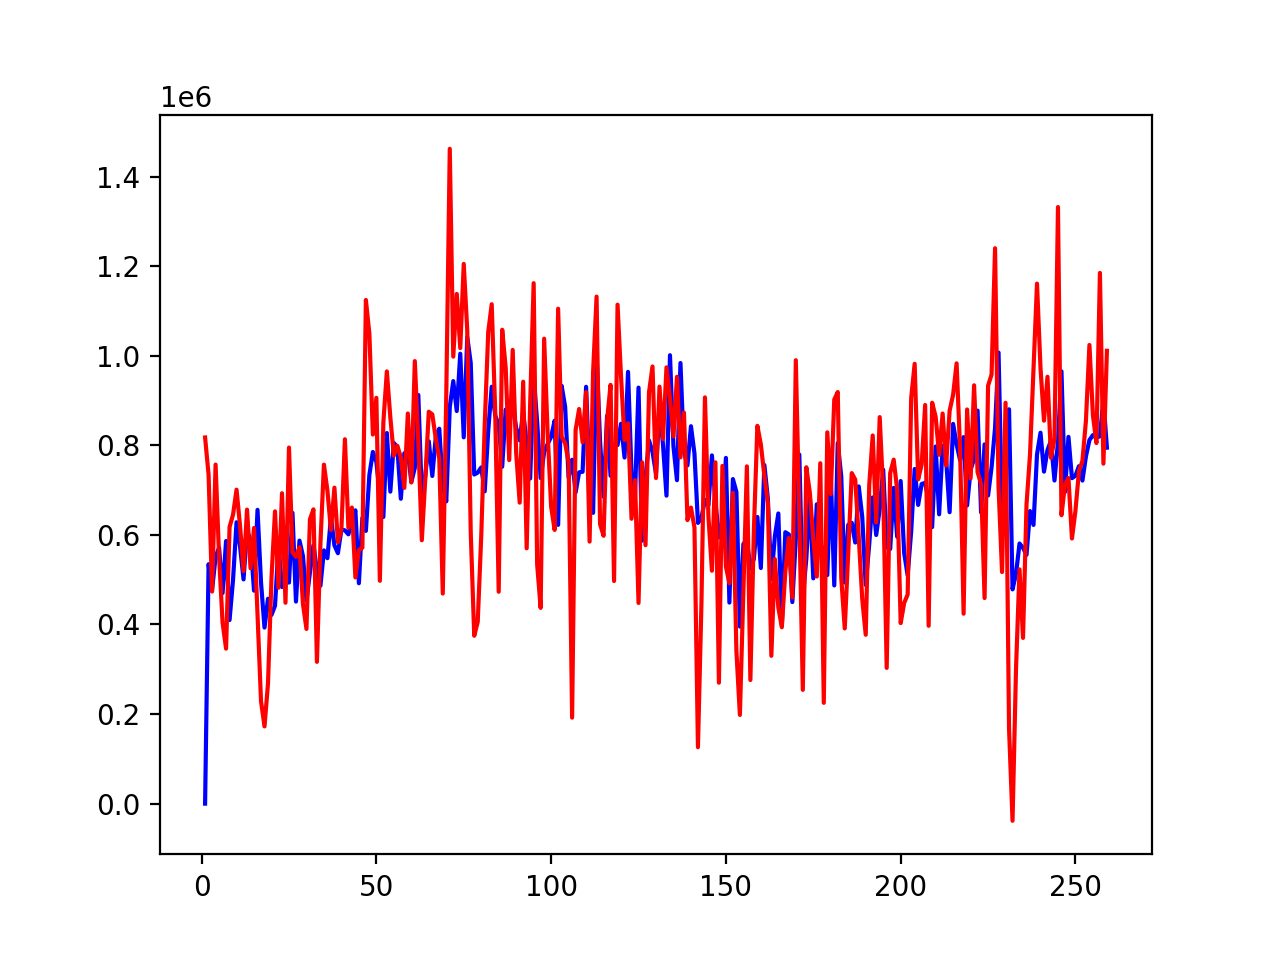

In [119]:
plt.plot(model_fit.predict(params=optimal[0][0]), color="blue")
plt.plot(train_data['Sales'], color="red")

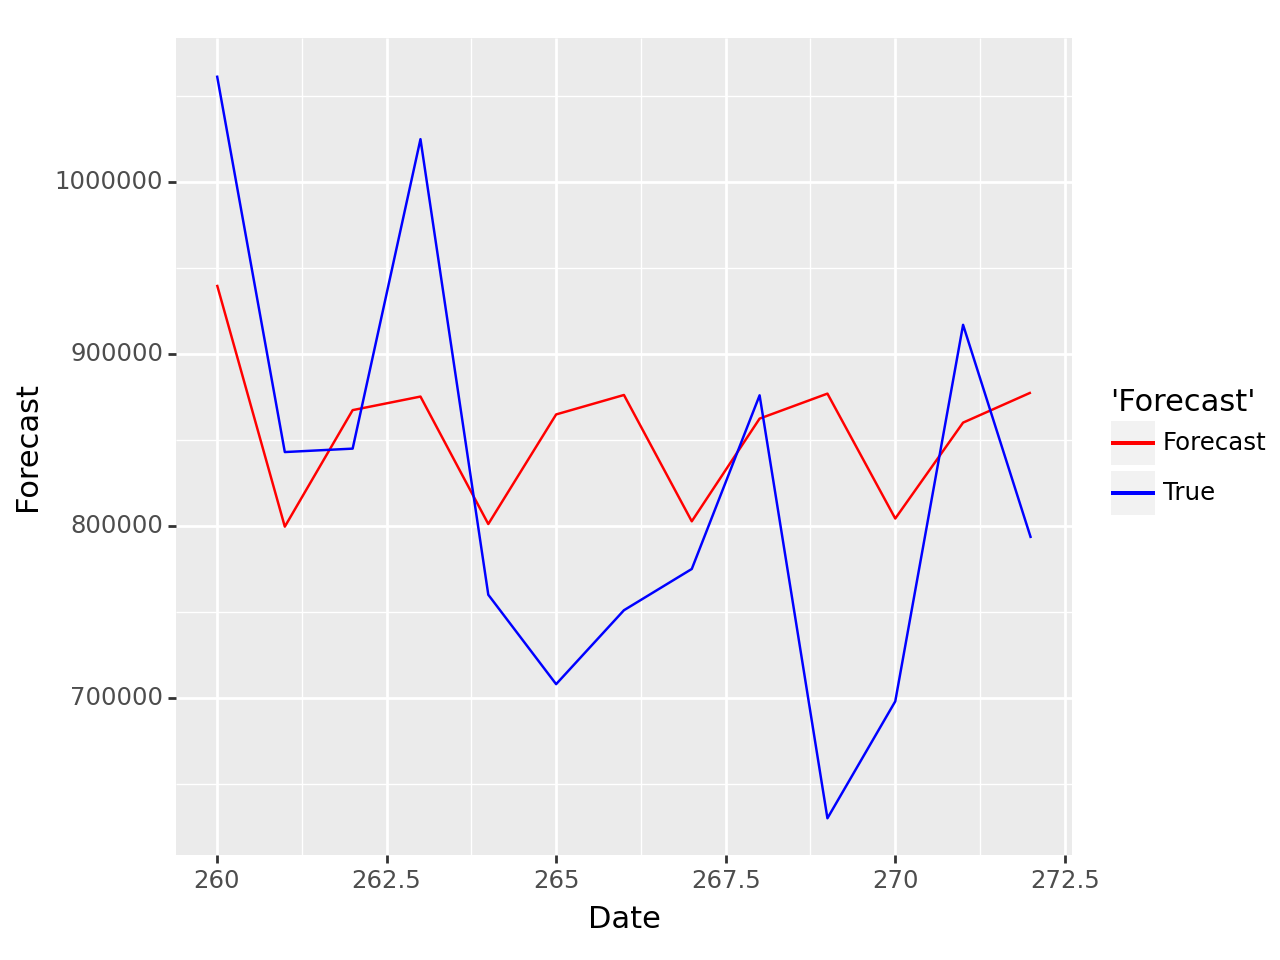

<Figure Size: (640 x 480)>

In [120]:
tmp = pd.DataFrame({'Forecast':np.array(forecast), 'True':np.array(test_data['Sales']), 'Date':test_data['Sales'].index})
(p9.ggplot(tmp, p9.aes(x='Date', group=1)) 
    +p9.geom_line(p9.aes(y='Forecast', color="'Forecast'")) 
    +p9.geom_line(p9.aes(y='True', color="'True'"))
    +p9.scale_color_manual(values={
         'Forecast' : 'red',
         'True':'blue'
     }))

In [430]:
evaluation(y_true=test_data['Sales'], y_pred=forecast)
y_pred_arima = forecast

MAD: 92040.96351515598, MAPD: 0.1188801516514899


# Machine learning

In [395]:
from pytimekr import pytimekr
kr_holidays = pytimekr.holidays(year=2023)

In [402]:
df = pd.concat([train_data, test_data])

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['holiday'] = df['Date'].isin(kr_holidays).astype(int)

# 데이터 타입 확인 및 변환 (필요한 경우)
# 여기서는 모든 열이 이미 적절한 데이터 타입을 가지고 있음

# 결측치 처리 (이 데이터에는 결측치가 없음)

# 이동 평균 추가
num_lags = 6
df['Sales_day_MA'] = df['Sales'].rolling(window=num_lags).mean()

# 카테고리 변수 인코딩 - Weekday (One-Hot 인코딩 사용)
df = pd.get_dummies(df, columns=['Weekday'])

# 결과 확인
df.head()

,index,Date,Sales,Year,Month,Day,holiday,Sales_day_MA,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_6
1,2,2023-01-03,817500.0,2023,1,3,0,NaN,False,True,False,False,False,False
2,3,2023-01-04,734000.0,2023,1,4,0,NaN,False,False,True,False,False,False
3,4,2023-01-05,473500.0,2023,1,5,0,NaN,False,False,False,True,False,False
4,5,2023-01-06,757000.0,2023,1,6,0,NaN,False,False,False,False,True,False
5,7,2023-01-08,551500.0,2023,1,8,0,NaN,False,False,False,False,False,True


In [403]:
for i in range(1, num_lags+1):
    df[f'Sales_Lag_{i}'] = df['Sales'].shift(i)

# 처음은 이동 평균이 없기 때문에 해당 행을 제거
df = df.dropna().reset_index(drop=True)

df

,index,Date,Sales,Year,Month,Day,holiday,Sales_day_MA,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_6,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6
0,9,2023-01-10,346000.0,2023,1,10,0,544333.333333,False,True,False,False,False,False,404000.0,551500.0,757000.0,473500.0,734000.0,817500.0
1,10,2023-01-11,617500.0,2023,1,11,0,524916.666667,False,False,True,False,False,False,346000.0,404000.0,551500.0,757000.0,473500.0,734000.0
2,11,2023-01-12,645500.0,2023,1,12,0,553583.333333,False,False,False,True,False,False,617500.0,346000.0,404000.0,551500.0,757000.0,473500.0
3,12,2023-01-13,701000.0,2023,1,13,0,544250.000000,False,False,False,False,True,False,645500.0,617500.0,346000.0,404000.0,551500.0,757000.0
4,14,2023-01-15,620000.0,2023,1,15,0,555666.666667,False,False,False,False,False,True,701000.0,645500.0,617500.0,346000.0,404000.0,551500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,313,2023-11-10,876000.0,2023,11,10,0,815833.333333,False,False,False,False,True,False,775000.0,751000.0,708000.0,760000.0,1025000.0,845000.0
262,315,2023-11-12,630000.0,2023,11,12,0,750000.000000,False,False,False,False,False,True,876000.0,775000.0,751000.0,708000.0,760000.0,1025000.0
263,316,2023-11-13,698000.0,2023,11,13,0,739666.666667,True,False,False,False,False,False,630000.0,876000.0,775000.0,751000.0,708000.0,760000.0
264,317,2023-11-14,917000.0,2023,11,14,0,774500.000000,False,True,False,False,False,False,698000.0,630000.0,876000.0,775000.0,751000.0,708000.0


In [404]:
tr_idx = df.loc[df["Date"]=='2023-11-01'].index
df.drop(['index', 'Date', 'Year', 'Month'],axis=1, inplace=True)
tr_idx

Index([253], dtype='int64')

In [405]:
train_data_ml = df.loc[1:tr_idx.item()-1]
test_data_ml = df.loc[tr_idx.item():]

In [406]:
train_data_ml

,Sales,Day,holiday,Sales_day_MA,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_6,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6
1,617500.0,11,0,524916.666667,False,False,True,False,False,False,346000.0,404000.0,5.515000e+05,7.570000e+05,4.735000e+05,734000.000000
2,645500.0,12,0,553583.333333,False,False,False,True,False,False,617500.0,346000.0,4.040000e+05,5.515000e+05,7.570000e+05,473500.000000
3,701000.0,13,0,544250.000000,False,False,False,False,True,False,645500.0,617500.0,3.460000e+05,4.040000e+05,5.515000e+05,757000.000000
4,620000.0,15,0,555666.666667,False,False,False,False,False,True,701000.0,645500.0,6.175000e+05,3.460000e+05,4.040000e+05,551500.000000
5,519000.0,16,0,574833.333333,True,False,False,False,False,False,620000.0,701000.0,6.455000e+05,6.175000e+05,3.460000e+05,404000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,867000.0,26,0,817901.603252,False,False,False,True,False,False,1024000.0,855000.0,7.654096e+05,7.420000e+05,6.540000e+05,592000.000000
249,805000.0,27,0,843068.269919,False,False,False,False,True,False,867000.0,1024000.0,8.550000e+05,7.654096e+05,7.420000e+05,654000.000000
250,1185000.0,29,0,916901.603252,False,False,False,False,False,True,805000.0,867000.0,1.024000e+06,8.550000e+05,7.654096e+05,742000.000000
251,759000.0,30,0,915833.333333,True,False,False,False,False,False,1185000.0,805000.0,8.670000e+05,1.024000e+06,8.550000e+05,765409.619513


In [407]:
test_data_ml.copy().reset_index(drop=True)

,Sales,Day,holiday,Sales_day_MA,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_6,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6
0,1062000.0,1,0,948166.666667,False,False,True,False,False,False,1011000.0,759000.0,1185000.0,805000.0,867000.0,1024000.0
1,843000.0,2,0,944166.666667,False,False,False,True,False,False,1062000.0,1011000.0,759000.0,1185000.0,805000.0,867000.0
2,845000.0,3,0,950833.333333,False,False,False,False,True,False,843000.0,1062000.0,1011000.0,759000.0,1185000.0,805000.0
3,1025000.0,5,0,924166.666667,False,False,False,False,False,True,845000.0,843000.0,1062000.0,1011000.0,759000.0,1185000.0
4,760000.0,6,0,924333.333333,True,False,False,False,False,False,1025000.0,845000.0,843000.0,1062000.0,1011000.0,759000.0
5,708000.0,7,0,873833.333333,False,True,False,False,False,False,760000.0,1025000.0,845000.0,843000.0,1062000.0,1011000.0
6,751000.0,8,0,822000.000000,False,False,True,False,False,False,708000.0,760000.0,1025000.0,845000.0,843000.0,1062000.0
7,775000.0,9,0,810666.666667,False,False,False,True,False,False,751000.0,708000.0,760000.0,1025000.0,845000.0,843000.0
8,876000.0,10,0,815833.333333,False,False,False,False,True,False,775000.0,751000.0,708000.0,760000.0,1025000.0,845000.0
9,630000.0,12,0,750000.000000,False,False,False,False,False,True,876000.0,775000.0,751000.0,708000.0,760000.0,1025000.0


In [408]:
def predict_with_lags(model, test_data, num_lags):
    # 테스트 데이터의 초기 복사본 생성
    test_data_simulated = test_data.copy().reset_index(drop=True)
    predictions = []

    # 첫 번째 날짜부터 마지막 날짜까지 반복
    for i in range(len(test_data_simulated)):
        # 현재 행의 특성을 사용하여 매출 예측
        current_prediction = model.predict(test_data_simulated.iloc[i].values.reshape(1, -1))
        predictions.append(current_prediction)

        # 다음 날짜가 존재하면, 예측값을 다음 날의 레그 특성으로 설정
        if i < len(test_data_simulated) - 1:
            for lag in range(1, num_lags):
                test_data_simulated.loc[i + 1, f'Sales_Lag_{num_lags - lag + 1}'] = test_data_simulated.loc[i, f'Sales_Lag_{num_lags - lag}']

            test_data_simulated.loc[i + 1, 'Sales_Lag_1'] = current_prediction

    return test_data_simulated, predictions

In [409]:
x_train = train_data_ml.drop(['Sales'], axis=1)
y_train = train_data_ml['Sales']

In [423]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

model = LGBMRegressor(verbose=0)

In [424]:
model.fit(x_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(verbose=0)

In [425]:
x_test = test_data_ml.drop(['Sales'], axis=1)
y_test = test_data_ml['Sales']
test_data_ml_real, y_pred = predict_with_lags(model, x_test, num_lags)

In [426]:
test_data_ml_real[test_data_ml_real.columns[9:]]

,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6
0,1.011000e+06,7.590000e+05,1.185000e+06,8.050000e+05,8.670000e+05,1.024000e+06
1,9.020933e+05,1.011000e+06,7.590000e+05,1.185000e+06,8.050000e+05,8.670000e+05
2,8.239033e+05,9.020933e+05,1.011000e+06,7.590000e+05,1.185000e+06,8.050000e+05
3,9.135052e+05,8.239033e+05,9.020933e+05,1.011000e+06,7.590000e+05,1.185000e+06
4,8.268687e+05,9.135052e+05,8.239033e+05,9.020933e+05,1.011000e+06,7.590000e+05
5,9.033891e+05,8.268687e+05,9.135052e+05,8.239033e+05,9.020933e+05,1.011000e+06
6,7.687526e+05,9.033891e+05,8.268687e+05,9.135052e+05,8.239033e+05,9.020933e+05
7,8.048599e+05,7.687526e+05,9.033891e+05,8.268687e+05,9.135052e+05,8.239033e+05
8,7.557577e+05,8.048599e+05,7.687526e+05,9.033891e+05,8.268687e+05,9.135052e+05
9,7.783465e+05,7.557577e+05,8.048599e+05,7.687526e+05,9.033891e+05,8.268687e+05


In [431]:
y_pred_lgbm = model.predict(test_data_ml_real)
evaluation(y_test, y_pred_lgbm)

MAD: 94904.8998199575, MAPD: 0.1138047464158128


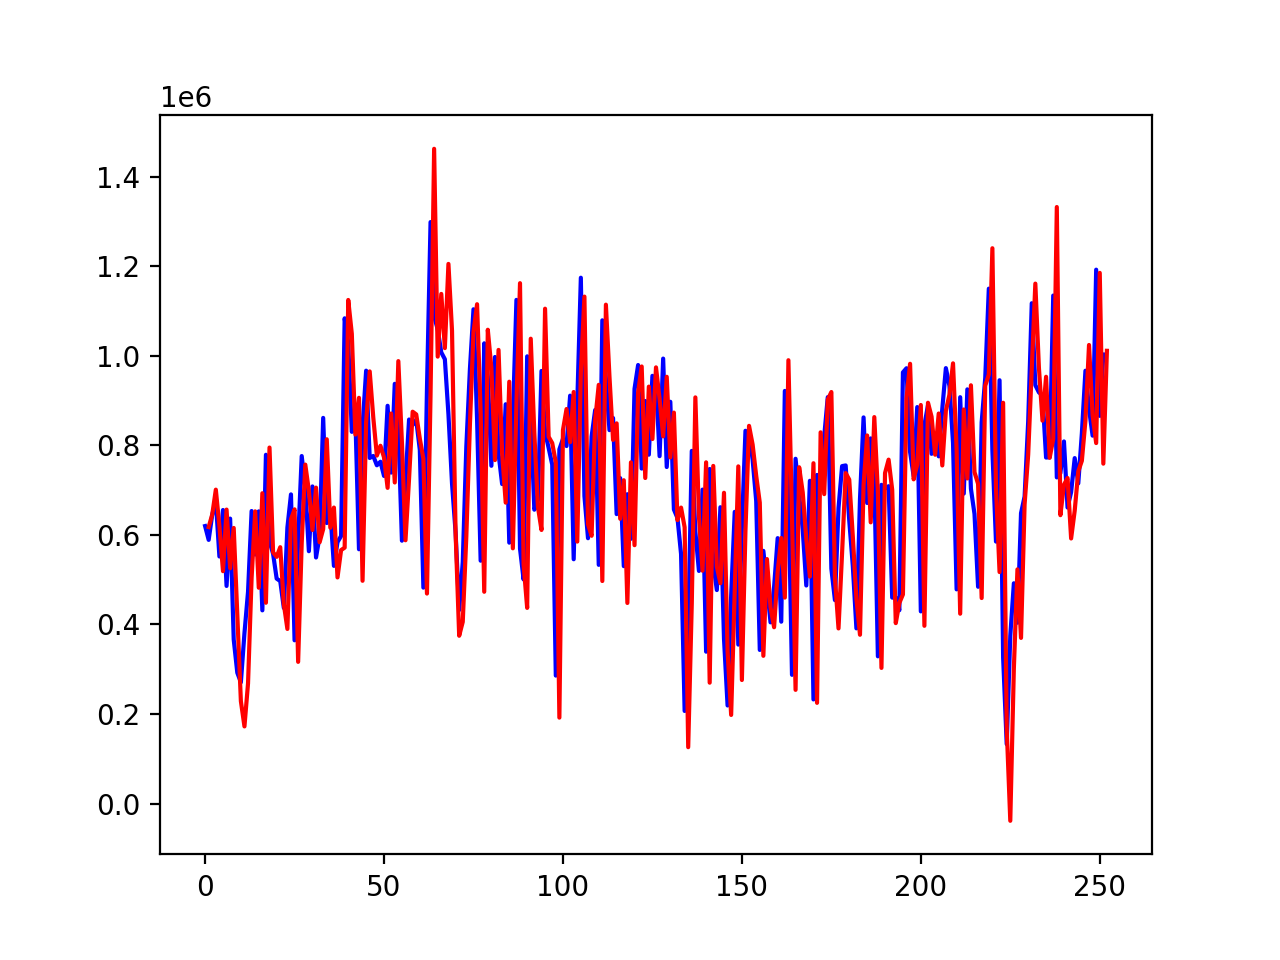

In [441]:
plt.plot(model.predict(x_train), color="blue")
plt.plot(train_data_ml['Sales'], color="red")

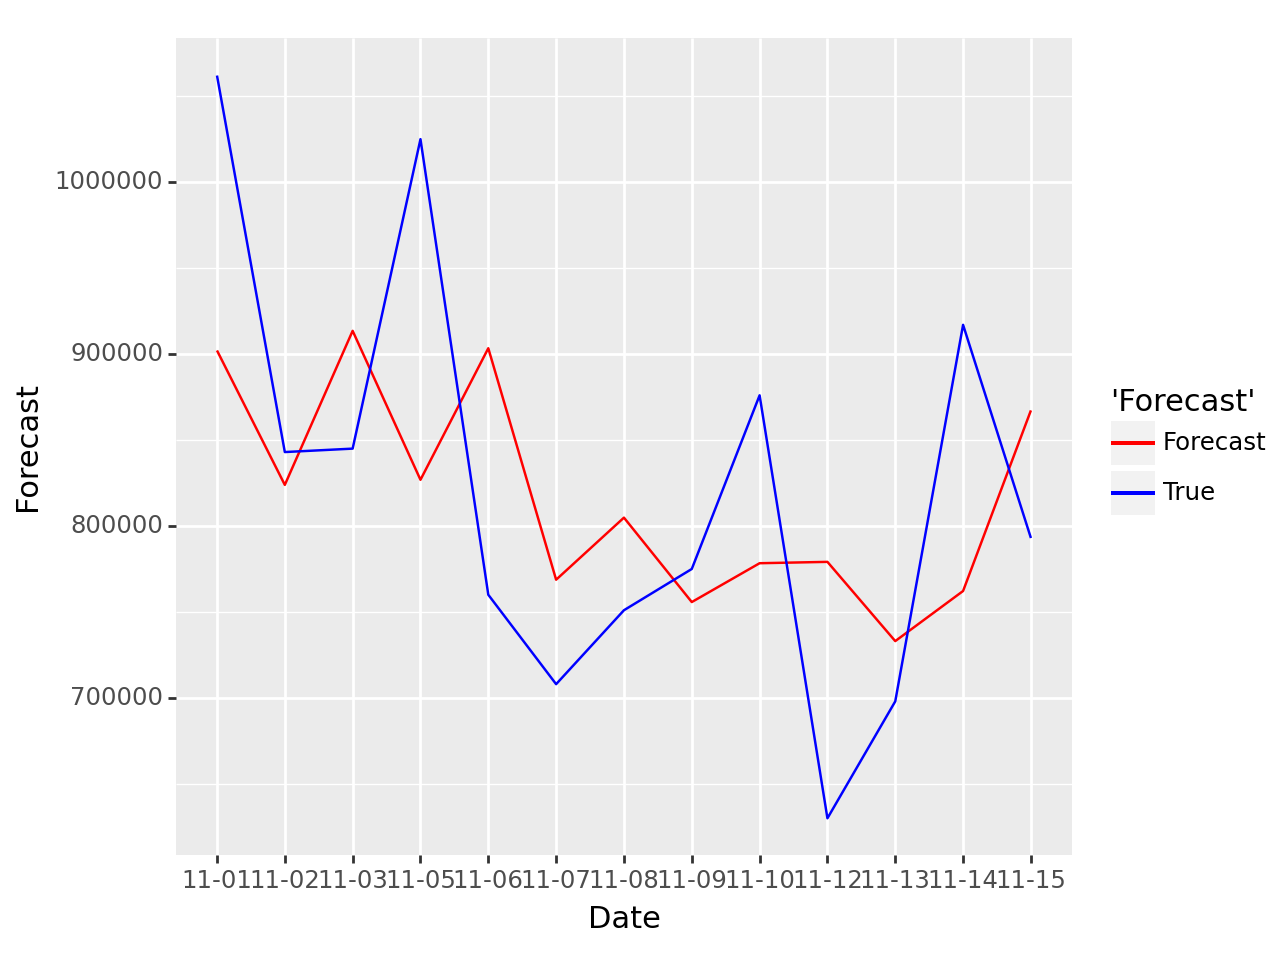

<Figure Size: (640 x 480)>

In [443]:
tmp = pd.DataFrame({'Forecast':np.array(y_pred_lgbm), 'True':np.array(y_test), 'Date':test_data['Date'].str.slice(start=5)})
(p9.ggplot(tmp, p9.aes(x='Date', group=1)) 
    +p9.geom_line(p9.aes(y='Forecast', color="'Forecast'")) 
    +p9.geom_line(p9.aes(y='True', color="'True'"))
    +p9.scale_color_manual(values={
         'Forecast' : 'red',
         'True':'blue'
     }))

In [444]:
y_pred_ensemble = (y_pred_arima + y_pred_lgbm)/2

In [445]:
evaluation(y_true=test_data['Sales'], y_pred=y_pred_ensemble)

MAD: 91992.75166213143, MAPD: 0.11443253934923159


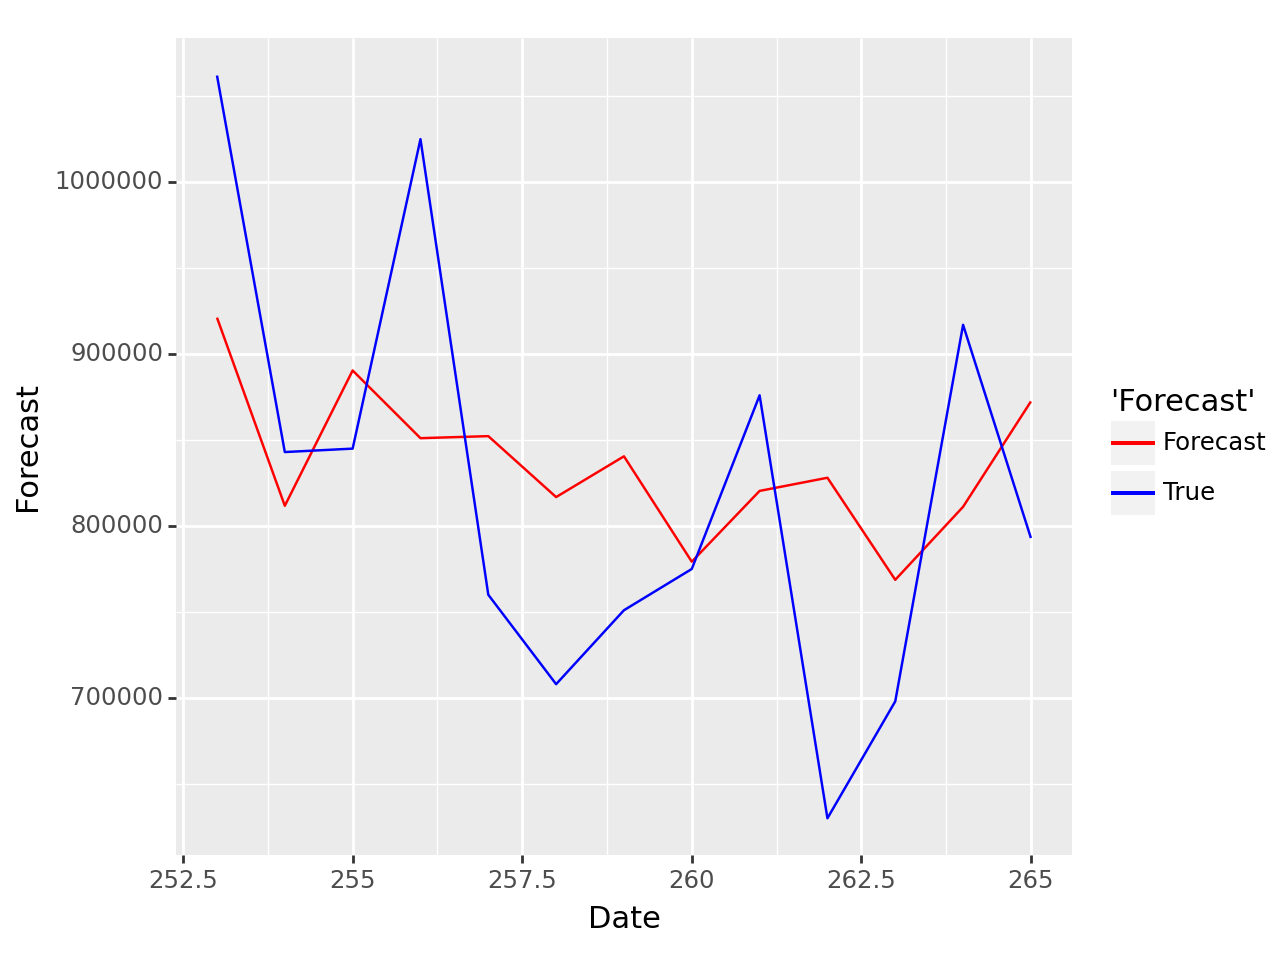

<Figure Size: (640 x 480)>

In [446]:
tmp = pd.DataFrame({'Forecast':np.array(y_pred_ensemble), 'True':np.array(y_test), 'Date':y_test.index})
(p9.ggplot(tmp, p9.aes(x='Date', group=1)) 
    +p9.geom_line(p9.aes(y='Forecast', color="'Forecast'")) 
    +p9.geom_line(p9.aes(y='True', color="'True'"))
    +p9.scale_color_manual(values={
         'Forecast' : 'red',
         'True':'blue'
     }))